### Name: Len Shu Yuan
### ID: 23083023


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Import the dataset


In [2]:
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path = 'chest_xray/val'

train_norm = len(os.listdir(train_path+'/NORMAL'))
train_pne = len(os.listdir(train_path+'/PNEUMONIA'))
print("Total number of images in training set:", (train_norm+train_pne))

test_norm = len(os.listdir(test_path+'/NORMAL'))
test_pne = len(os.listdir(test_path+'/PNEUMONIA'))
print("Total number of images in testing set:", (test_norm+test_pne))

val_norm = len(os.listdir(val_path+'/NORMAL'))
val_pne = len(os.listdir(val_path+'/PNEUMONIA'))
print("Total number of images in validation set:", (val_norm+val_pne))

os.listdir(train_path)

Total number of images in training set: 5216
Total number of images in testing set: 624
Total number of images in validation set: 18


['NORMAL', 'PNEUMONIA']

Class distribution in training set


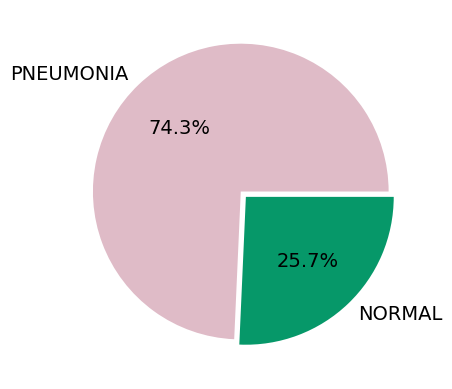

In [3]:
train_paths = []
train_labels = []

for label in os.listdir(train_path):
    for image in os.listdir(train_path+'/'+label):
        train_paths.append(train_path+label+'/'+image)
        train_labels.append(label)

print('Class distribution in training set')
colors = ['#DFBBC7', '#069869']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='PNEUMONIA']),
         len([x for x in train_labels if x=='NORMAL'])],
        labels=['PNEUMONIA', 'NORMAL'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025))
plt.show()

Class distribution in testing set


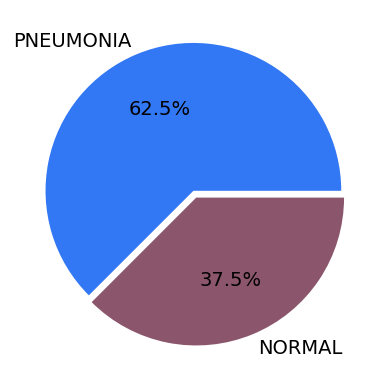

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_path):
    for image in os.listdir(test_path+'/'+label):
        test_paths.append(test_path+label+'/'+image)
        test_labels.append(label)

print('Class distribution in testing set')
colors = ['#3277f4', '#8b566c']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in test_labels if x=='PNEUMONIA']),
         len([x for x in test_labels if x=='NORMAL'])],
        labels=['PNEUMONIA', 'NORMAL'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025))
plt.show()

In [5]:
def plot_image(path, title):
    image_filenames = os.listdir(path)
    fig, axs = plt.subplots(1, 4, figsize=(20,10))
    for i in range(4):
        image_data = plt.imread(path + '/' + image_filenames[i])
        print(image_data.shape)
        axs[i].imshow(image_data, cmap="gray")
        axs[i].set_title(title)
    plt.show()

### Normal image

(1858, 2090)
(1152, 1422)
(1434, 1810)
(1279, 1618)


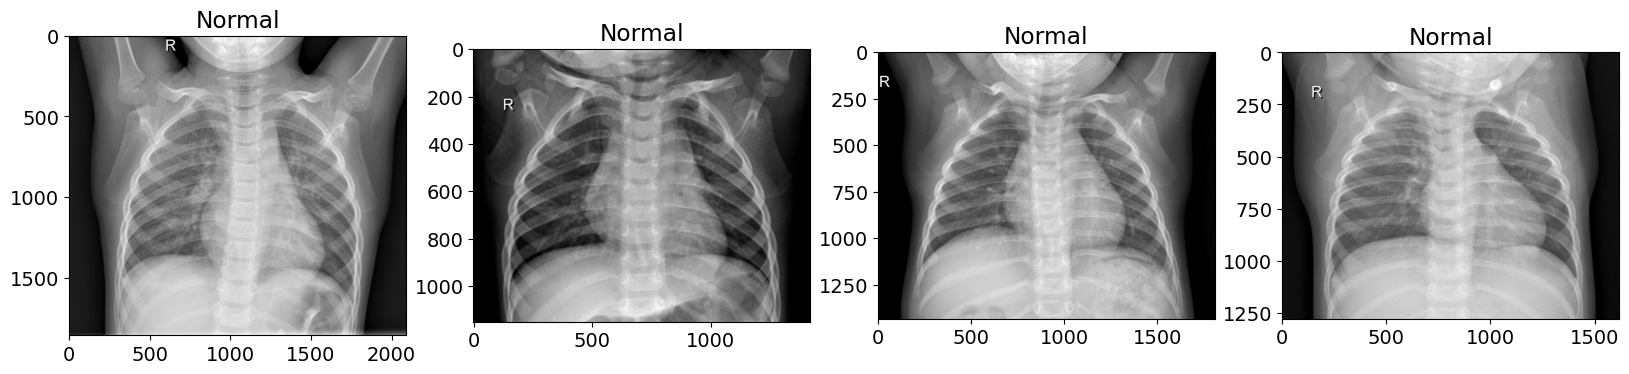

In [80]:
image_folder_path = train_path + '/NORMAL'
plot_image(image_folder_path, "Normal")

### Pneumonia image

(760, 1152)
(768, 1072)
(863, 1244)
(940, 1242)


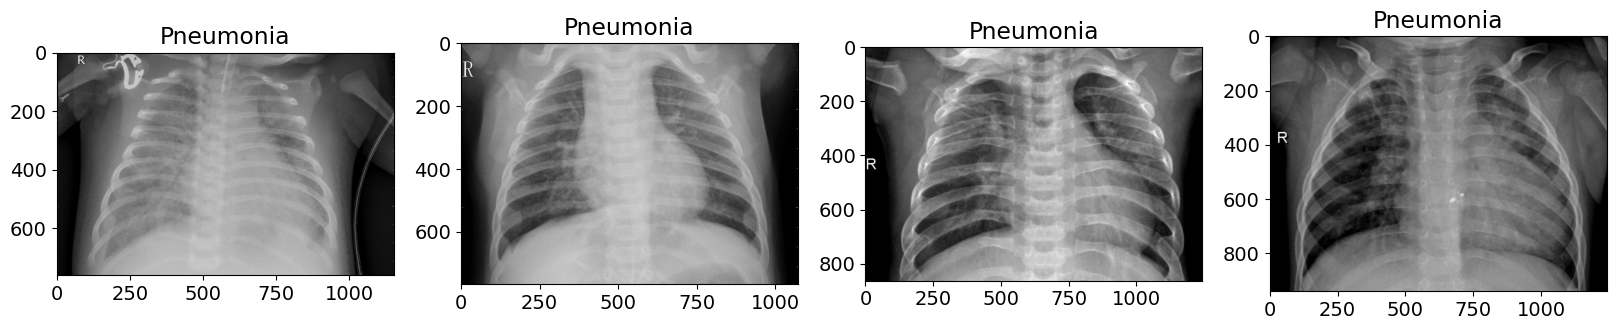

In [81]:
image_folder_path = train_path + '/PNEUMONIA'
plot_image(image_folder_path, "Pneumonia")

In [7]:
image_shape = (224,224,3)

# Data Augmentation

In [8]:
image_gen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2,
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip = True,  
        vertical_flip=False)  

train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='binary')
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False)
val_image_gen = image_gen.flow_from_directory(val_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Model

In [87]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape = image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), input_shape = image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), input_shape = image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model

In [90]:
early_stop = EarlyStopping(monitor='val_loss',patience=10, mode='min')
results = model.fit(train_image_gen, epochs=30,
                              validation_data = test_image_gen,
                              callbacks=[early_stop])

Epoch 1/30
163/163 [==============================] - 91s 556ms/step - loss: 3.1770 - accuracy: 0.7632 - val_loss: 0.5802 - val_accuracy: 0.7099
Epoch 2/30
163/163 [==============================] - 79s 483ms/step - loss: 0.4200 - accuracy: 0.8158 - val_loss: 0.5883 - val_accuracy: 0.7372
Epoch 3/30
163/163 [==============================] - 61s 375ms/step - loss: 0.4139 - accuracy: 0.8271 - val_loss: 0.5828 - val_accuracy: 0.7436
Epoch 4/30
163/163 [==============================] - 61s 375ms/step - loss: 0.3897 - accuracy: 0.8384 - val_loss: 0.5955 - val_accuracy: 0.7372
Epoch 5/30
163/163 [==============================] - 61s 375ms/step - loss: 0.4019 - accuracy: 0.8294 - val_loss: 0.6447 - val_accuracy: 0.7516
Epoch 6/30
163/163 [==============================] - 61s 376ms/step - loss: 0.3744 - accuracy: 0.8301 - val_loss: 0.5876 - val_accuracy: 0.7356
Epoch 7/30
163/163 [==============================] - 61s 376ms/step - loss: 0.3740 - accuracy: 0.8338 - val_loss: 0.5945 - val_ac

In [91]:
loss_df = pd.DataFrame(model.history.history)
loss_df.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

# Training vs validation loss

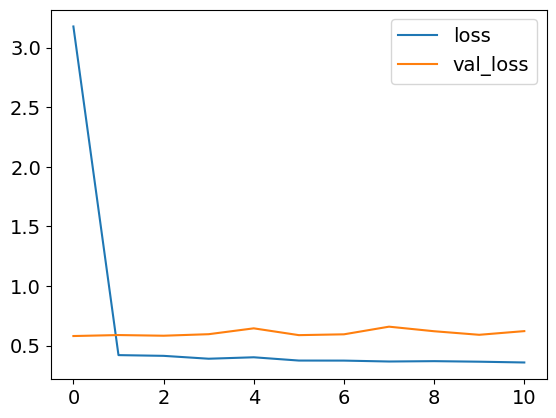

In [92]:
loss_df[['loss','val_loss']].plot()
plt.show()

# Training vs validation accuracy

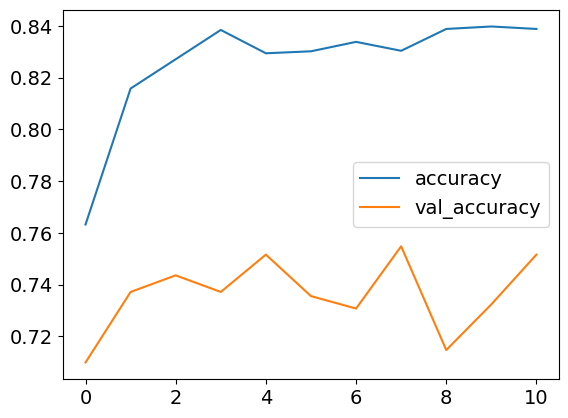

In [93]:
loss_df[['accuracy','val_accuracy']].plot()
plt.show()

# Evaluate the mode

In [94]:
model.evaluate(test_image_gen, verbose=0)

[0.618597149848938, 0.7483974099159241]

## Classification report

In [95]:
y_pred_cnn = model.predict(test_image_gen)
y_pred_cnn = y_pred_cnn.round()
y_true_cnn = test_image_gen.classes
print(classification_report(y_true_cnn,y_pred_cnn))

20/20 [==============================] - 6s 299ms/step
              precision    recall  f1-score   support

           0       0.73      0.47      0.57       234
           1       0.74      0.90      0.81       390

    accuracy                           0.74       624
   macro avg       0.74      0.68      0.69       624
weighted avg       0.74      0.74      0.72       624



## Confusion matrix

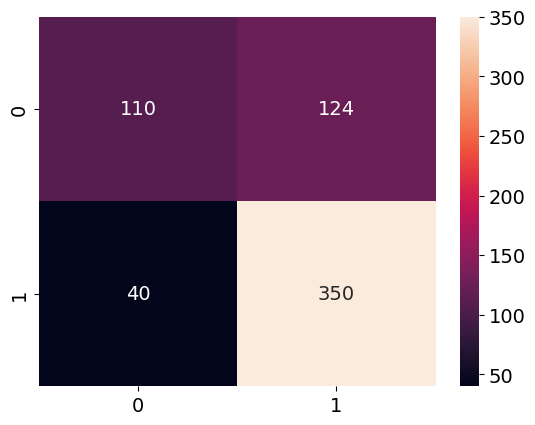

In [96]:
cnf = confusion_matrix(y_true_cnn,y_pred_cnn)
sns.heatmap(cnf, annot=True, fmt='g')
plt.show()

## AUC ROC curve




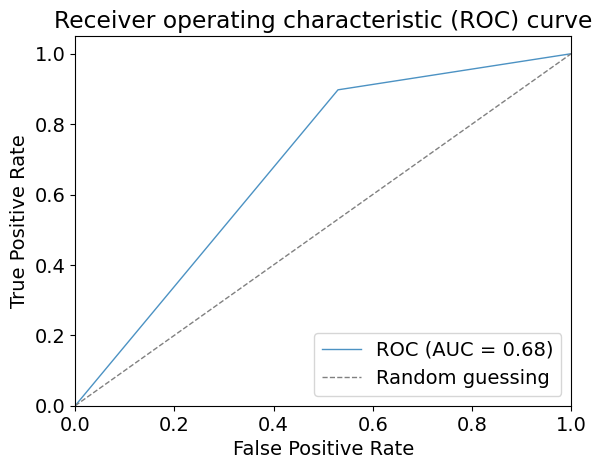

In [97]:
fpr, tpr, thresholds = roc_curve(y_true_cnn, y_pred_cnn)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - CNN')
plt.legend(loc="lower right")
plt.show()

# VGG 16

In [100]:
vgg = VGG16(input_shape=image_shape, weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(1, activation='sigmoid')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = modelvgg.fit(train_image_gen, epochs=20,
                              validation_data = test_image_gen,
                              callbacks=[early_stop])

Epoch 1/20
163/163 [==============================] - 65s 383ms/step - loss: 1.3443 - accuracy: 0.9103 - val_loss: 1.7398 - val_accuracy: 0.8734
Epoch 2/20
163/163 [==============================] - 61s 376ms/step - loss: 1.2031 - accuracy: 0.9287 - val_loss: 10.7757 - val_accuracy: 0.7500
Epoch 3/20
163/163 [==============================] - 61s 376ms/step - loss: 1.0200 - accuracy: 0.9448 - val_loss: 4.3934 - val_accuracy: 0.8381
Epoch 4/20
163/163 [==============================] - 61s 375ms/step - loss: 0.9941 - accuracy: 0.9509 - val_loss: 8.9575 - val_accuracy: 0.7644
Epoch 5/20
163/163 [==============================] - 61s 375ms/step - loss: 0.8665 - accuracy: 0.9609 - val_loss: 5.2482 - val_accuracy: 0.8349
Epoch 6/20
163/163 [==============================] - 61s 375ms/step - loss: 0.8352 - accuracy: 0.9594 - val_loss: 5.4183 - val_accuracy: 0.8381
Epoch 7/20
163/163 [==============================] - 61s 375ms/step - loss: 1.0367 - accuracy: 0.9563 - val_loss: 7.2189 - val_a

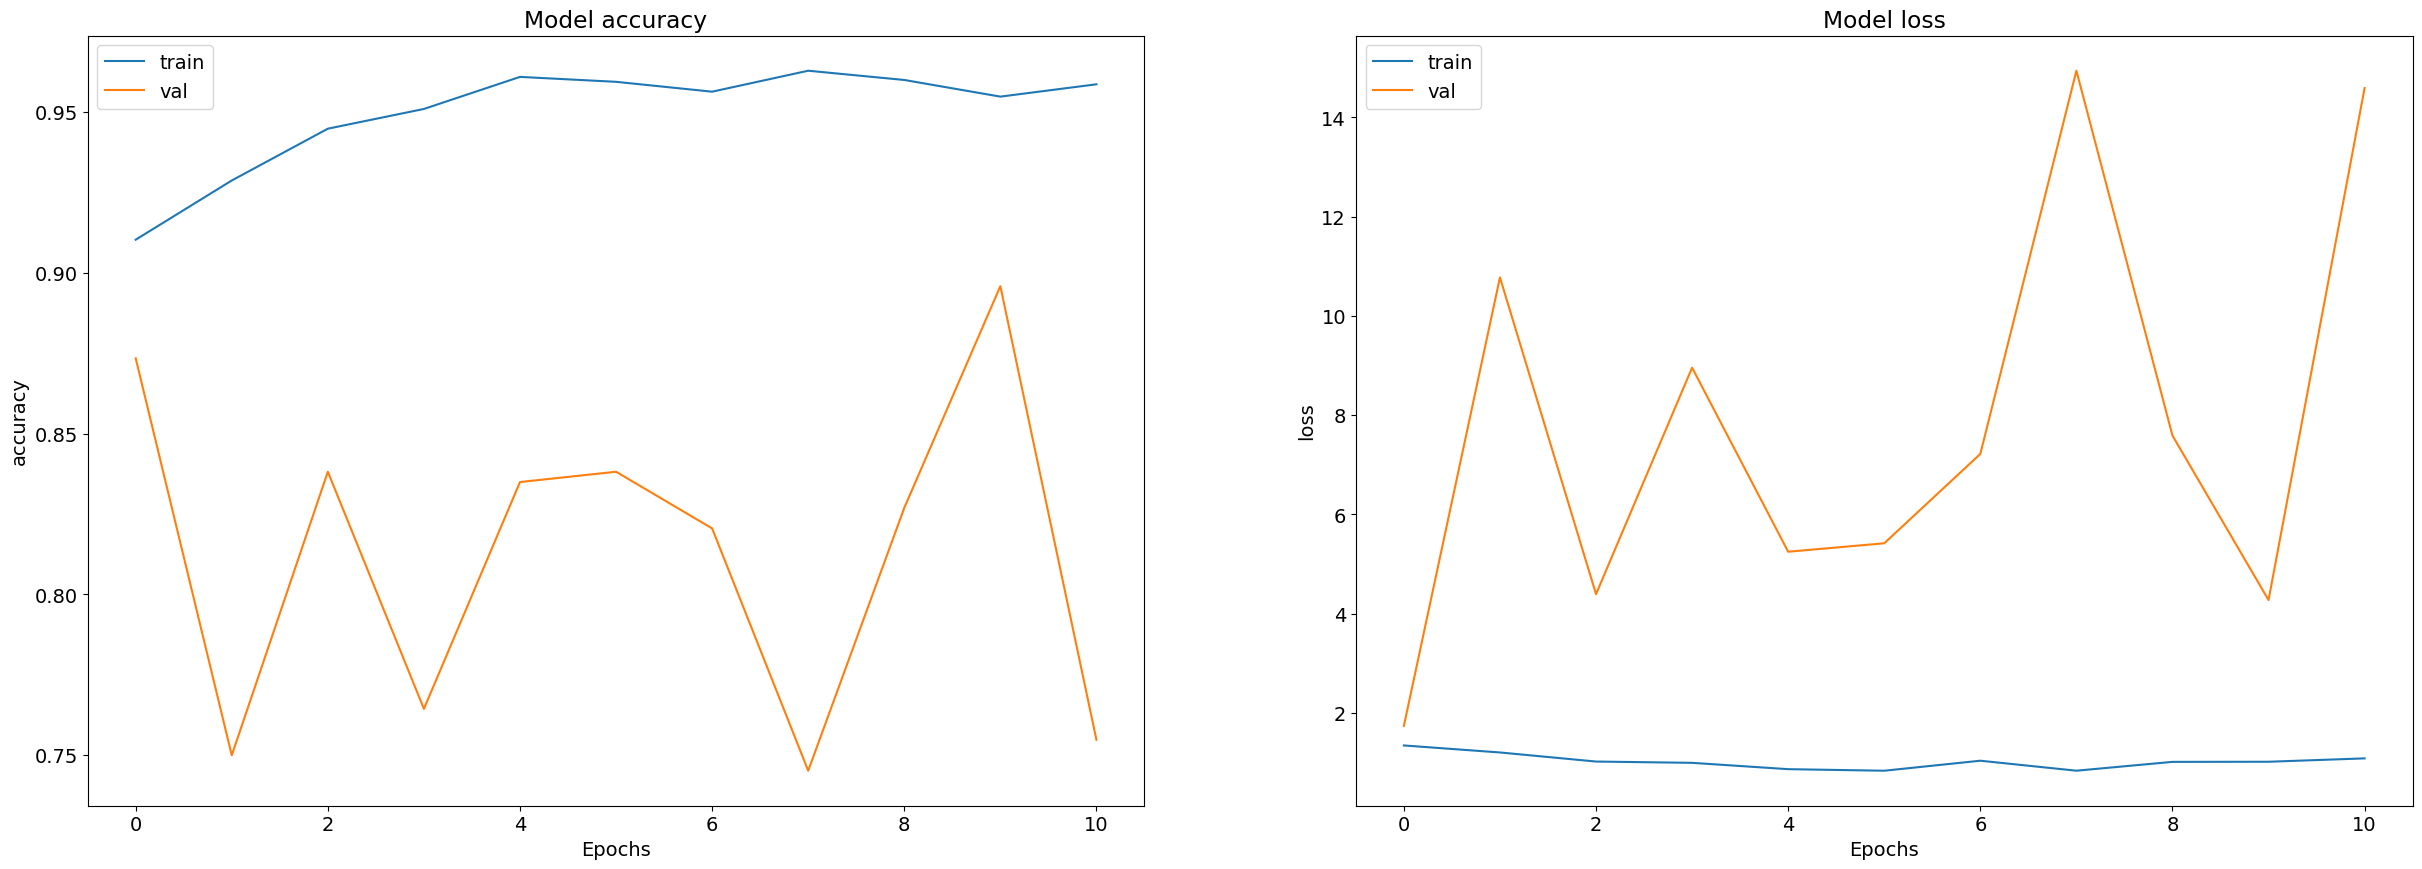

In [101]:
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
y_pred_vgg = modelvgg.predict(test_image_gen)
y_pred_vgg = y_pred_vgg.round()
y_true_vgg = test_image_gen.classes
print(classification_report(y_true_vgg,y_pred_vgg))

20/20 [==============================] - 6s 285ms/step
              precision    recall  f1-score   support

           0       1.00      0.41      0.58       234
           1       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.87      0.71      0.72       624
weighted avg       0.84      0.78      0.75       624



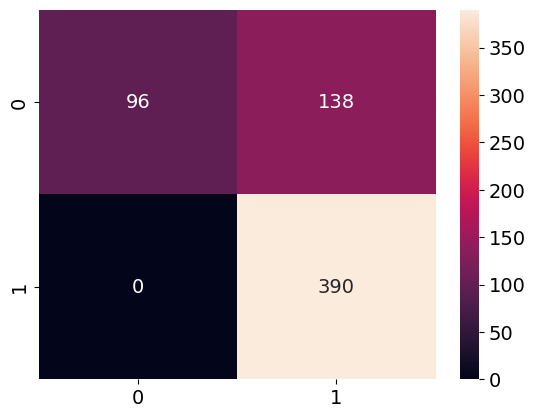

In [112]:
cnf = confusion_matrix(y_true_vgg,y_pred_vgg)
sns.heatmap(cnf, annot=True, fmt='g')
plt.show()

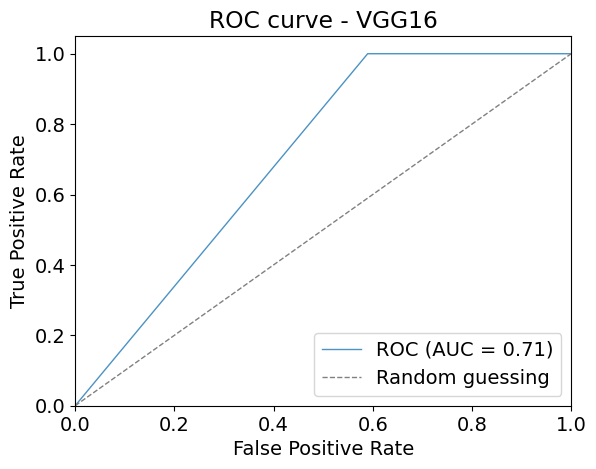

In [113]:
fpr, tpr, thresholds = roc_curve(y_true_vgg, y_pred_vgg)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - VGG16')
plt.legend(loc="lower right")
plt.show()

# ResNet50

In [106]:
res = ResNet50(input_shape=image_shape, weights='imagenet', include_top=False)
for layer in res.layers:
    layer.trainable = False
x = Flatten()(res.output)

prediction = Dense(1, activation='sigmoid')(x)

res50 = Model(inputs=res.input, outputs=prediction)

res50.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = res50.fit(train_image_gen, epochs=10,
                              validation_data = test_image_gen,
                              callbacks=[early_stop])

Epoch 1/10
163/163 [==============================] - 63s 374ms/step - loss: 1.0927 - accuracy: 0.9185 - val_loss: 1.3577 - val_accuracy: 0.8558
Epoch 2/10
163/163 [==============================] - 57s 349ms/step - loss: 0.4814 - accuracy: 0.9479 - val_loss: 4.6806 - val_accuracy: 0.7772
Epoch 3/10
163/163 [==============================] - 57s 347ms/step - loss: 0.6237 - accuracy: 0.9526 - val_loss: 2.0011 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 56s 345ms/step - loss: 0.5239 - accuracy: 0.9609 - val_loss: 4.1088 - val_accuracy: 0.8061
Epoch 5/10
163/163 [==============================] - 56s 343ms/step - loss: 0.8379 - accuracy: 0.9532 - val_loss: 4.1698 - val_accuracy: 0.8478
Epoch 6/10
163/163 [==============================] - 63s 388ms/step - loss: 0.5713 - accuracy: 0.9649 - val_loss: 4.8380 - val_accuracy: 0.8189
Epoch 7/10
163/163 [==============================] - 61s 370ms/step - loss: 0.4858 - accuracy: 0.9663 - val_loss: 3.7493 - val_ac

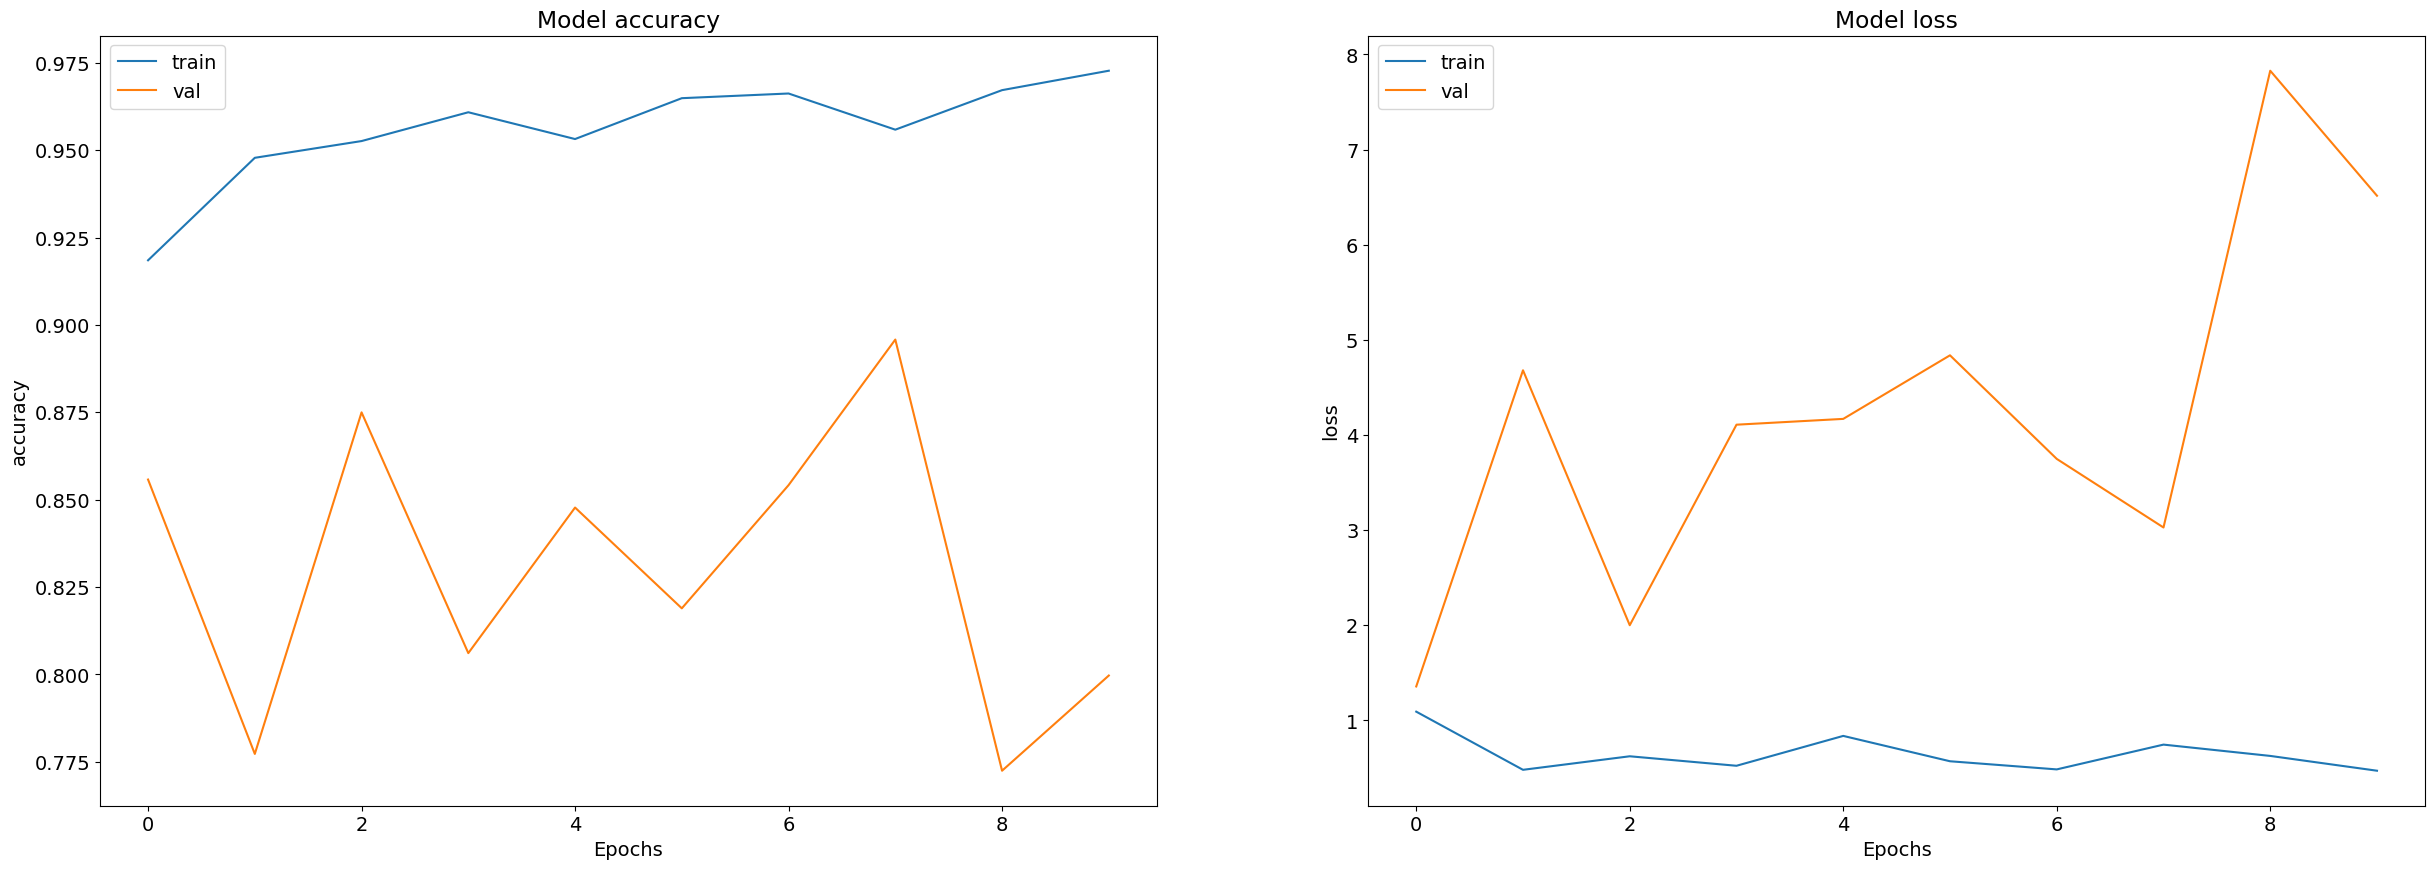

In [107]:
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history2.history[metric])
    ax[i].plot(history2.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [108]:

y_pred_resnet = res50.predict(test_image_gen)
y_pred_resnet = y_pred_resnet.round()
y_true_resnet = test_image_gen.classes
print(classification_report(y_true_resnet,y_pred_resnet))

20/20 [==============================] - 7s 286ms/step
              precision    recall  f1-score   support

           0       0.98      0.51      0.67       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



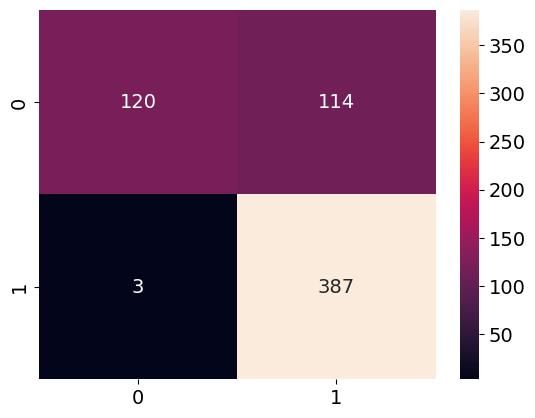

In [ ]:
cnf = confusion_matrix(y_true_resnet,y_pred_resnet)
sns.heatmap(cnf, annot=True, fmt='g')
plt.show()

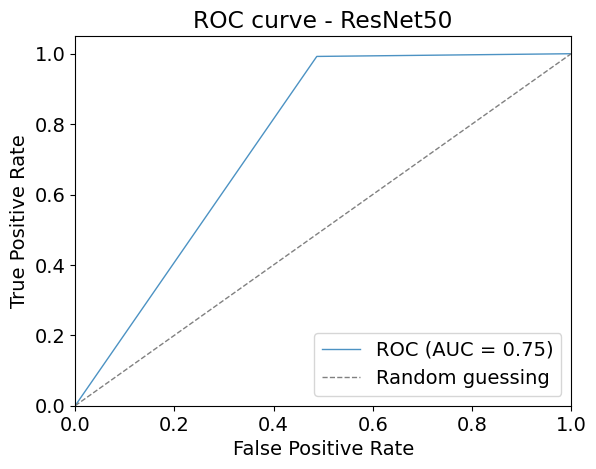

In [110]:
fpr, tpr, thresholds = roc_curve(y_true_resnet, y_pred_resnet)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - ResNet50')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Save VGG model
modelvgg.save('vgg_model.h5')
#Save ResNet model
res50.save('res50.h5')

# XAI Methods

In [9]:
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras

# Load pre-trained models
vgg_model = load_model('vgg_model2.h5')
resnet_model = load_model('res502.h5')

# Define image dimensions
image_shape = (224, 224, 3)  

# Prepare test image paths
test_normal_dir = 'test/NORMAL/'
test_pneumonia_dir = 'test/PNEUMONIA/'

test_normal_images = [os.path.join(test_normal_dir, fname) for fname in os.listdir(test_normal_dir) if fname.endswith('.jpeg')]
test_pneumonia_images = [os.path.join(test_pneumonia_dir, fname) for fname in os.listdir(test_pneumonia_dir) if fname.endswith('.jpeg')]

# Create a list of tuples with display names and full paths
test_images_list = [('Normal: ' + os.path.basename(path), path) for path in test_normal_images] + [('Pneumonia: ' + os.path.basename(path), path) for path in test_pneumonia_images]

# Streamlit app title
st.title('Pneumonia Image Classification Dashboard with Grad-CAM and Saliency Map')

# User input selections
selected_option = st.selectbox('Select an image', [option[0] for option in test_images_list])
model_selection = st.selectbox('Select a Model', ('VGG16', 'ResNet50'))

# Get the full path of the selected image
selected_image_path = next(path for label, path in test_images_list if label == selected_option)

# Preprocess the selected image
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(image_shape[0], image_shape[1]), color_mode='rgb')
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, image

# Grad-CAM function
def generate_gradcam_heatmap(model, img_array, last_conv_layer_name):
    grad_model = keras.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        top_class = tf.argmax(predictions[0])  # Index of the top prediction
        loss = tf.reduce_mean(predictions[:, top_class])
        top_class_grad = tape.gradient(loss, conv_outputs)

    # Compute the channel-wise mean of gradients
    weights = tf.reduce_mean(top_class_grad, axis=(0, 1, 2))
    gradcam = np.zeros(conv_outputs.shape[1:3], dtype=np.float32)

    # Weight each channel by corresponding gradient
    for i, w in enumerate(weights):
        gradcam += w * conv_outputs[0, :, :, i]
    
    # Apply ReLU
    gradcam = np.maximum(gradcam, 0)

    # Normalize the heatmap
    gradcam = gradcam / np.max(gradcam)
    return gradcam

# Overlay Grad-CAM on original image
def overlay_gradcam_on_image(image, heatmap, alpha=0.4):
    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay_image = cv2.addWeighted(heatmap, alpha, np.array(image), 1 - alpha, 0)
    return overlay_image

# Saliency Map function with enhanced visualization
def generate_saliency_map(model, img_array):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        top_class = tf.argmax(predictions[0])
        loss = predictions[0, top_class]

    gradients = tape.gradient(loss, img_tensor)
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)

    # Normalize the saliency map to [0, 1]
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))

    # Remove batch dimension (if present)
    saliency_map = np.squeeze(saliency_map.numpy())  

    # Convert the saliency map to 0-255 range (uint8 format)
    saliency_map = np.uint8(255 * saliency_map)  

    # Apply color map
    saliency_map = cv2.applyColorMap(saliency_map, cv2.COLORMAP_JET)  

    return saliency_map


# Load and preprocess the image
img_array, image = load_and_preprocess_image(selected_image_path)

# Select the model based on user choice
if model_selection == 'VGG16':
    model = vgg_model
    last_conv_layer_name = 'block5_conv3'  
elif model_selection == 'ResNet50':
    model = resnet_model
    last_conv_layer_name = 'conv5_block3_out'  

# Display the image
st.image(image, caption='Selected X-ray Image', use_container_width=True)

# Display the prediction probability
prediction = model.predict(img_array)
probability = prediction[0][0] 

st.write('Model:' + model_selection)
# Classify based on probability threshold (e.g., 0.5)
if probability > 0.5:
    st.write('Prediction: Pneumonia')
else:
    st.write('Prediction: Normal')

# Generate Grad-CAM heatmap
heatmap = generate_gradcam_heatmap(model, img_array, last_conv_layer_name)
heatmap = 1 - heatmap
# Overlay the heatmap on the original image
heatmap_overlay = overlay_gradcam_on_image(np.array(image), heatmap)

# Display Grad-CAM heatmap
st.image(heatmap_overlay, caption='Grad-CAM Heatmap', use_container_width=True)

# Generate Saliency Map
saliency_map = generate_saliency_map(model, img_array)

# Overlay the saliency map on the original image
saliency_overlay = overlay_gradcam_on_image(np.array(image), saliency_map)

# Display Saliency Map
st.image(saliency_map, caption='Saliency Map', use_container_width=True)
st.image(saliency_overlay, caption='Saliency Overlay', use_container_width=True)

2025-01-17 11:21:46.964 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:47.279 
  command:

    streamlit run C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-01-17 11:21:47.279 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:47.279 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:47.279 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:47.279 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:47.279 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:47.279 Session

1/1 [==============================] - 3s 3s/step


2025-01-17 11:21:50.286 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:50.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:50.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:50.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:50.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:50.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:50.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 11:21:50.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

# References

Dateset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Code references:
1. https://www.kaggle.com/code/shuvostp/pneumonia-classification-cnn-vgg19-and-resnet50
2. https://www.kaggle.com/code/willstone98/grad-cam-and-saliency
